# NASA Asteroids Classification

Analyzes the public repository of Near Earth Objects (dataset available at [kaggle](https://www.kaggle.com/datasets/lovishbansal123/nasa-asteroids-classification/data)) to identify possibly hazardous asteroids.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
nasa_df = pd.read_csv("data/nasa.csv")

## Data cleaning

In [27]:
# First we notice that `Neo Reference ID` a `Name` are identical columns. Similarly, the `Orbiting Body` column is constant since these are all objects orbiting the Earth, and the `Equinox` column is also constant equal to `J2000`.
columns_to_drop = ["Neo Reference ID", "Orbiting Body", "Equinox", "Close Approach Date", "Orbit Determination Date"]

# There are two date columns which we will first convert to proper date objects, and then encode as independent day,month,year columns as well as minutes,hours.
cad_column = pd.to_datetime(nasa_df["Close Approach Date"])
nasa_df["Close Approach Date (day)"] = cad_column.dt.day
nasa_df["Close Approach Date (month)"] = cad_column.dt.month
nasa_df["Close Approach Date (year)"] = cad_column.dt.year

odd_column = pd.to_datetime(nasa_df["Orbit Determination Date"])
nasa_df["Orbit Determination Date (day)"] = odd_column.dt.day
nasa_df["Orbit Determination Date (month)"] = odd_column.dt.month
nasa_df["Orbit Determination Date (year)"] = odd_column.dt.year
nasa_df["Orbit Determination Date (hours)"] = odd_column.dt.hour
nasa_df["Orbit Determination Date (minutes)"] = odd_column.dt.minute
nasa_df["Orbit Determination Date (seconds)"] = odd_column.dt.second

This dataset has no missing entries so we can skip this part.

In [33]:
X = nasa_df.drop(["Hazardous"] + columns_to_drop, axis=1)
y = nasa_df["Hazardous"]

The proportion of hazardous elements in the set determines the accuracy score one expects when picking random answers.

In [66]:
baseline_probability = y.sum() / y.count()
baseline_probability

0.16108384894388736

There are no categorical features, only numerical so we apply a simple MinMax scaling.

In [43]:
from sklearn.preprocessing import MinMaxScaler

preprocessor = MinMaxScaler()
X_prep = pd.DataFrame(preprocessor.fit_transform(X))
X_prep.columns = X.columns

## Prediction

In [47]:
from sklearn.model_selection import train_test_split, validation_curve, ValidationCurveDisplay, cross_val_score
from sklearn.metrics import classification_report

We start with a simple Logistic Regression with hyperparameters tuning.

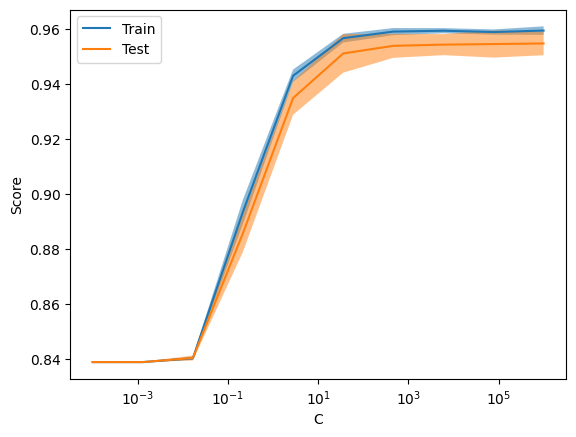

In [53]:
from sklearn.linear_model import LogisticRegression

ValidationCurveDisplay.from_estimator(
    LogisticRegression(solver="lbfgs", max_iter=1_000),
    X_prep,
    y,
    param_name="C",
    param_range=np.logspace(-4, 6, 10),
)

In [54]:
model_lr = LogisticRegression(C=100, solver="lbfgs", max_iter=1_000, random_state=0)

scores = cross_val_score(model_lr, X_prep, y, cv=5)
display(scores.mean())

0.9522110441844747

We get roughly 95% accuracy. What about a Random Forest Classifier?

In [60]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)

scores = cross_val_score(model_rf, X_prep, y, cv=5)
display(scores.mean())

0.9968003404232079

Already a much better result as expect from a more robust model. What about the popular xgboost?

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X_prep, y, test_size=0.3, random_state=0)

In [62]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=2,
    learning_rate=0.2,
    subsample=0.3,
    n_estimators=1000,
    early_stopping_rounds=5,
)

model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

y_predict_xgb = model_xgb.predict(X_valid)[:, 1]

[0]	validation_0-mlogloss:0.51697
[1]	validation_0-mlogloss:0.39835
[2]	validation_0-mlogloss:0.31366
[3]	validation_0-mlogloss:0.25033
[4]	validation_0-mlogloss:0.20301
[5]	validation_0-mlogloss:0.16586
[6]	validation_0-mlogloss:0.13593
[7]	validation_0-mlogloss:0.11247
[8]	validation_0-mlogloss:0.09390
[9]	validation_0-mlogloss:0.07945
[10]	validation_0-mlogloss:0.06747
[11]	validation_0-mlogloss:0.05832
[12]	validation_0-mlogloss:0.05081
[13]	validation_0-mlogloss:0.04437
[14]	validation_0-mlogloss:0.03926
[15]	validation_0-mlogloss:0.03469
[16]	validation_0-mlogloss:0.03126
[17]	validation_0-mlogloss:0.02869
[18]	validation_0-mlogloss:0.02657
[19]	validation_0-mlogloss:0.02519
[20]	validation_0-mlogloss:0.02413
[21]	validation_0-mlogloss:0.02346
[22]	validation_0-mlogloss:0.02280
[23]	validation_0-mlogloss:0.02217
[24]	validation_0-mlogloss:0.02156
[25]	validation_0-mlogloss:0.02140
[26]	validation_0-mlogloss:0.02141
[27]	validation_0-mlogloss:0.02073
[28]	validation_0-mlogloss:0.0

In [64]:
print(classification_report(y_valid, y_predict_xgb))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1181
        True       0.99      0.98      0.98       226

    accuracy                           0.99      1407
   macro avg       0.99      0.99      0.99      1407
weighted avg       0.99      0.99      0.99      1407

